In [4]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file. 
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [5]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
    # import pytorch3d
# except ModuleNotFoundError:
    # need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{torch.__version__[0:5:2]}"
#         ])
#         !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
#         !tar xzf 1.10.0.tar.gz
#         os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
#         !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [6]:
import os
import torch
from torch import nn
from torchvision.transforms import RandomAffine, Resize
import optuna


import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torchvision.transforms import RandomAffine, Resize

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    NormalMeshRenderer,
    MeshRasterizer,  
    NormalSoftPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    tbn_matrices,
)

from pytorch3d.renderer.mesh import tbn_matrices
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [7]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [8]:
 from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [9]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [10]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
# obj_filename = os.path.join(DATA_DIR, "cube_mesh/six_colour_cube.obj")


# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((0.75 / float(scale)));

In [11]:
# cos_similarity = torch.nn.CosineSimilarity(dim=3)
# transform_range_horizontal = 100/1024
# transform_range_vertical = 100/1024
# transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical), fill=0.5)
# cos_similarity(mesh.normalmaps.maps_padded(), transform(mesh.normalmaps.maps_padded().permute(0,3,1,2)).permute(0,2,3,1).squeeze().cpu().numpy()).mean()

In [12]:
# plt.figure(figsize=(7,7))
# texture_image=mesh.normalmaps.maps_padded()
# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().numpy())
# plt.axis("off");

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


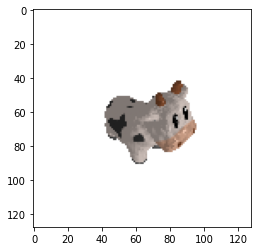

In [13]:
imsize = 128
# lights = PointLights(device=device, location=[[0.0, 0.0, -1.5]])
lights = DirectionalLights(direction=[[0.0, 0.0, -1.0]], device=device)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = 45
rand_azim = 135
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
TBN_matrices = tbn_matrices(mesh)
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)
random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
plt.imshow(random_target.cpu().numpy()[0])

In [14]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20
batch_views = 1
imsize = 128
# Get a batch of viewing angles. 
elev = np.random.permutation(torch.linspace(0, 360, num_views))
azim = np.random.permutation(torch.linspace(-180, 180, num_views))
# elev = np.array([45, 45, 225, 225])
# azim = np.array([-45, 135, -45, 135])

def train_test_split(list):
    return list[:len(list)//2], list[len(list)//2:]

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
# cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = torch.rand((1,))*360
rand_azim = torch.rand((1,))*360 - 180
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 

normals_hook = torch.Tensor()
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)

# for i
# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_views)
target_rgb = []
target_cameras = []
target_normals = []
print()
# Render small batches of target views on GPU and append to list to be later converted to CPU tensor
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    target_images_batch, normals = renderer(meshes, cameras=cameras, lights=lights)

    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_rgb_batch = [target_images_batch[i, ..., :3].cpu() for i in range(batch_views)]
    target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_rgb.extend(target_rgb_batch)
    target_cameras.extend(target_cameras_batch)
    target_normals.append(normals)


# 50/50 split of views for train/test
target_rgb, test_rgb = train_test_split(target_rgb)
target_cameras, test_cameras = train_test_split(target_cameras)
target_normals, test_normals = train_test_split(target_normals)

random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
print(len(target_rgb), len(target_cameras))


10 10


Visualize the dataset:

/tmp/ipykernel_924/1255958388.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)
/tmp/ipykernel_924/1255958388.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)


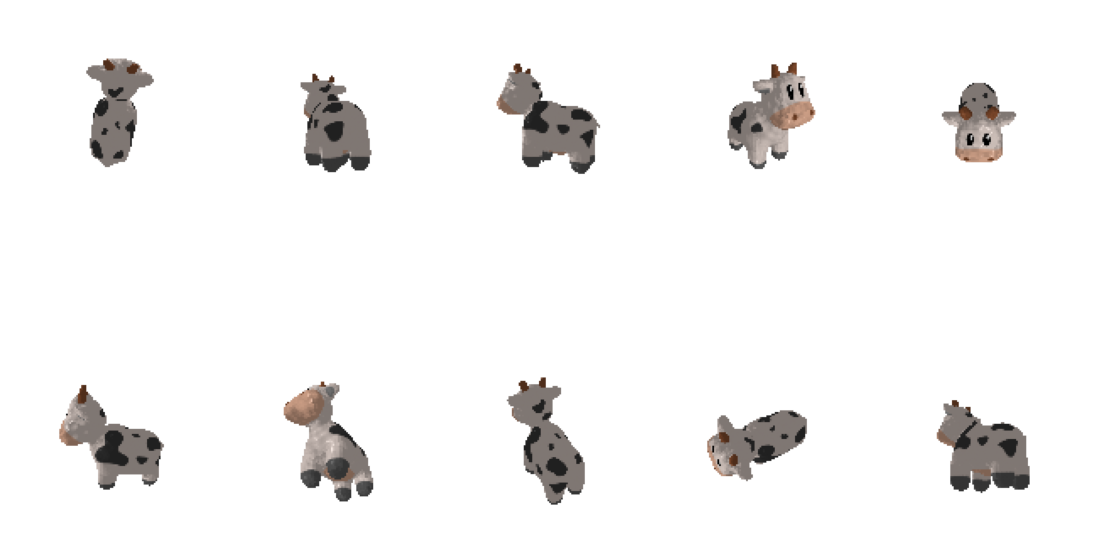

In [15]:
# RGB images
print()

image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)
plt.show()

Later in this tutorial, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object.  We construct a soft silhouette shader to render this alpha channel.

In [16]:
# # Rasterization settings for silhouette rendering  
# sigma = 1e-4
# raster_settings_silhouette = RasterizationSettings(
#     image_size=imsize, 
#     blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
#     faces_per_pixel=50, 
#     perspective_correct=False,
# )

# # Silhouette renderer 
# renderer_silhouette = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings_silhouette
#     ),
#     shader=SoftSilhouetteShader()
# )

# # # Render silhouette images.  The 3rd channel of the rendering output is 
# # # the alpha/silhouette channel
# # silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
# # print(silhouette_images.shape)
# # target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# # # Visualize silhouette images
# # image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
# # plt.show()

/tmp/ipykernel_924/579964652.py:37: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.asarray(target_silhouette[:10])[0].shape)
/tmp/ipykernel_924/579964652.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.asarray(target_silhouette[:10])[0].shape)
/tmp/ipykernel_924/579964652.py:38: FutureWarning: The input object of type 'Tensor' is an array-like 

torch.Size([128, 128])


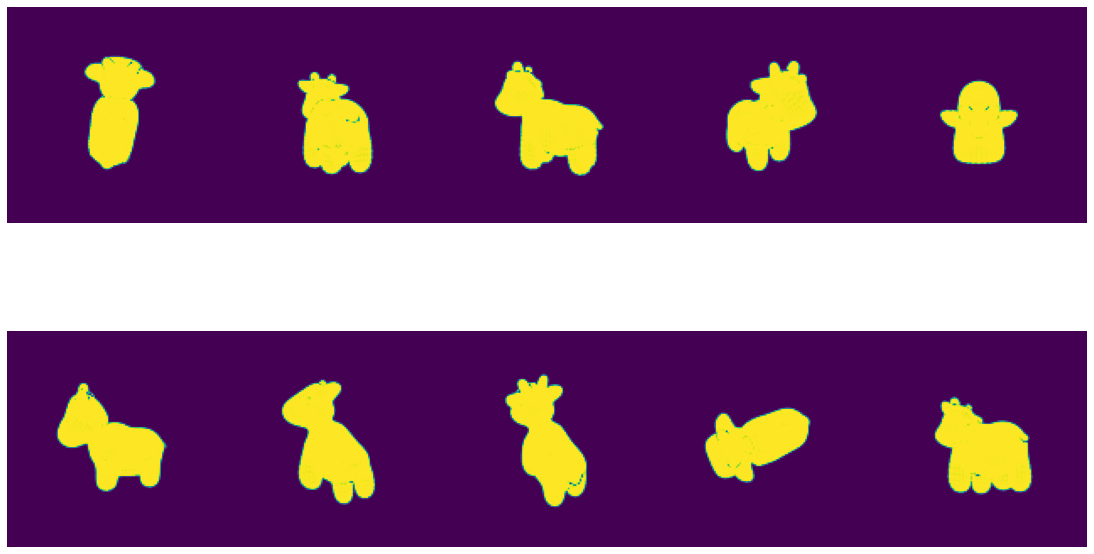

In [17]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
target_silhouette = []
silhouette_images = []
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    silhouette_images_batch = renderer_silhouette(meshes, cameras=cameras, lights=lights)
    silhouette_images.extend(silhouette_images_batch.cpu())
    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_silhouette_batch = [silhouette_images_batch[i, ..., 3].cpu() for i in range(batch_views)]
    # target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                        #    T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_silhouette.extend(target_silhouette_batch)
    # target_cameras.extend(target_cameras_batch)
# Visualize silhouette images
print(np.asarray(target_silhouette[:10])[0].shape)
image_grid(np.asarray(silhouette_images[:10]), rows=2, cols=5, rgb=False)
plt.show()

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [18]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=random_target[0], title='', 
                         silhouette=False, camera = camera):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images, _ = renderer(predicted_mesh, cameras=camera)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [19]:
# We initialize the source shape to be a sphere of radius 1.  
silhouette_src_mesh = ico_sphere(4, device)
# src_mesh = mesh.clone()

torch.Size([2562]) torch.Size([2562])
torch.Size([2562, 2]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Target shapes faces: torch.Size([1, 5856, 3]), verts: torch.Size([1, 2930, 3])
Target shapes facesUVs: torch.Size([1, 5856, 3]), vertsUVs: torch.Size([1, 3225, 2])
torch.Size([2562, 3])


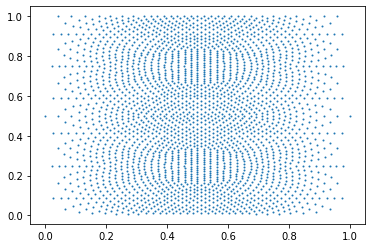

In [20]:
# Functions from my L4 project
def to_geocentric(lat, lon):
    """
    Converts a latitude longitude pair to geocentric X Y Z coordinates
    """
    lat = np.radians(lat)
    lon = np.radians(lon)
    return np.array([np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)])

# lat lon but longitude is scaled to half to have a square representation
def to_lat_lon(coords):
    """
    Converts X Y Z geocentric coordinates into latitude and longitude
    """
    return np.array([np.degrees(np.arcsin(coords[2])), np.degrees(np.arctan2(coords[1], coords[0]))])

# Creating UVs for sphere using equirectangular projection with scaled v axis
sphere_verts = silhouette_src_mesh.verts_packed()
xyz_to_u = torch.rad2deg(torch.arcsin(sphere_verts[:,2])) + 90
xyz_to_v = (torch.rad2deg(torch.atan2(sphere_verts[:,1], sphere_verts[:,0])) + 180) / 2 
print(xyz_to_u.shape, xyz_to_v.shape)
sphere_verts_uvs = torch.stack([xyz_to_u, xyz_to_v], dim=1) / 180
print(sphere_verts_uvs.shape, sphere_verts_uvs.max(), sphere_verts_uvs.min())
# need to solve seams somehow
# u = 0.5 + (torch.atan2(verts[:,0], verts[:,1])/(np.pi*2))
# v = 0.5 - (torch.arcsin(verts[:,2])/np.pi)
# uv_map = torch.stack([u,v], dim=1).unsqueeze(dim=0).to(device)
print("Target shapes faces: {}, verts: {}".format(mesh.faces_padded().shape, mesh.verts_padded().shape, ))
print("Target shapes facesUVs: {}, vertsUVs: {}".format(mesh.textures.faces_uvs_padded().shape,  mesh.textures.verts_uvs_padded().shape))
print(silhouette_src_mesh.verts_packed().shape)
# silhouette_src_mesh.verts_padded().map
plt.scatter(sphere_verts_uvs.cpu()[:,0], sphere_verts_uvs.cpu()[:,1], s=1)
plt.show()
silhouette_src_mesh.textures = TexturesUV(mesh.textures.maps_padded(), faces_uvs=silhouette_src_mesh.faces_packed().unsqueeze(0), verts_uvs=sphere_verts_uvs.unsqueeze(0))

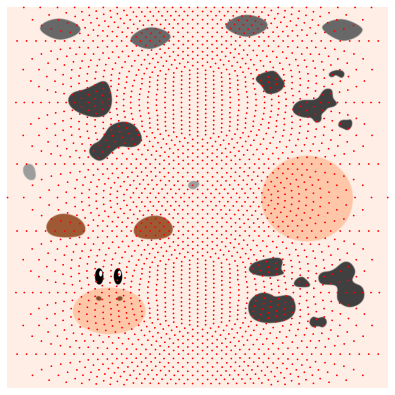

In [21]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=src_mesh.textures.maps_padded()
texturesuv_image_matplotlib(silhouette_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

In [22]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

In [23]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 5
# Number of optimization steps
Niter = 1000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = silhouette_src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the silhouettes of the target images:

In [24]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = silhouette_src_mesh.offset_verts(deform_verts)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j].to(device)) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    # if i % plot_period == 0:
    #     visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
    #                          target_image=target_silhouette[1])
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
# sum_loss=None
silhouette_result = new_src_mesh.clone().detach()
# visualize_prediction(silhouette_result, silhouette=True, 
#                      target_image=target_silhouette[1], camera=target_cameras[1])
# plot_losses(losses)

## 3. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

In [26]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019

new_TBN_matrices = tbn_matrices(silhouette_result)

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=NormalSoftPhongShader(device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=new_TBN_matrices)
)


We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

In [27]:

# Texture generator Code
class Generator(nn.Module):
    def __init__(self, ngpu, ngf = 32, nc=3, nz=100, type = "normal", conv_layers = 4):
        super(Generator, self).__init__()
        self.type = type
        self.ngpu = ngpu
        self.deconv = nn.Sequential(
            # Testing convoluting target image first 
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Flatten(),
            nn.Linear(ngf * 4 * 16*16, nz),
            UnsqueezeLatent(),
        )
        self.tanh = nn.Tanh()           
        scale_factor = max(8, 8*(2**(4-conv_layers)))
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear')
        self.normal_generator = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
        )
        self.texture_generator = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
        )

        if type == "normal":
            self.generator = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
                # nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*8) x 4 x 4
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*4) x 8 x 8
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*2) x 16 x 16
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf) x 32 x 32
                # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
                # nn.BatchNorm2d(ngf//2),
                # nn.ReLU(True),
                # nn.Dropout2d(),
                # state size. (ngf) x 64 x 64
                nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
                nn.Tanh(),
                # nn.Upsample(scale_factor=4, mode='bilinear')
                # state size. (nc) x 128 x 128
            )
        elif type == "residual":
            self.generator =  nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*8) x 4 x 4
            ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*4) x 8 x 8
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*2) x 16 x 16
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf//2),
            # nn.ReLU(True),
            # nn.Dropout2d(),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh(),
            # nn.Upsample(scale_factor=4, mode='bilinear')
            # state size. (nc) x 128 x 128
        )
        elif type == "simultaneous":
            modules = [nn.ConvTranspose2d(nz, ngf * (2**(conv_layers-1)), 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * (2**(conv_layers-1))),
                nn.ReLU(True)]

            # deconv layers that upscale by 2, maximum to 128x128
            for i in range(conv_layers - 1, max(conv_layers-4, 0), -1):
                modules.extend([
                nn.ConvTranspose2d(ngf * (2**(i)), ngf * (2**(i-1)), 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * (2**(i-1))),
                nn.ReLU(True)
                ])
            # convolution layers without upscaling beyond 128x128 to save on memory
            if conv_layers > 4:
                for j in range(conv_layers-4, 0, -1):
                    modules.extend([
                        nn.ConvTranspose2d(ngf * (2**(j)), ngf * (2**(j-1)), 3, 1, 1, bias=False),
                        nn.BatchNorm2d(ngf * (2**(j-1))),
                        nn.ReLU(True) 
                    ])

            self.generator = nn.Sequential(*modules)
    def forward(self, input):
        if self.type == "simultaneous":
            result = self.generator(input)
            return self.upsampler(self.tanh(self.texture_generator(result))), self.upsampler(self.tanh(self.normal_generator(result)))
        else: 
            return self.generator(input)


In [28]:
# Discriminator code
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf = 32, nc = 3):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            # state size. (ndf*8) x 8 x 8
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [29]:


%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
map_losses = {
          "rgb": {"weight": 1.0, "values": []},
        #   "silhouette": {"weight": 1.0, "values": []},
        #   "edge": {"weight": 1.0, "values": []},
        #   "normal": {"weight": 0.01, "values": []},
        #   "laplacian": {"weight": 1.0, "values": []},
          # "style": {"weight": 1.0, "values": []},
          # "adversarial": {"weight": 0.01, "values": []},
          "smoothness":{"weight":0.1, "values": []},
          "normal_smoothness":{"weight":0.1, "values": []}
         }
losses_gan = {
          "generator": {"weight": 1.0, "values": []},
          "discriminator":{"weight":1.0, "values": []}

}
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
# src_mesh = mesh.clone()
# verts_shape = src_mesh.verts_packed().shape
# deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# verts = src_mesh.verts_packed().to(device)
# .faces_packed().unsqueeze(dim=0).to(device)
faces_uvs = silhouette_result.textures.faces_uvs_padded()
uv_map = silhouette_result.textures.verts_uvs_padded()
# print(uv_map.shape, src_mesh.textures.verts_uvs_padded().shape)
# uv_map.requires_grad = True

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh
# sphere_verts_rgb = torch.full(mesh.textures.maps_padded().shape, 0.1, device=device, requires_grad=True)
# sphere_verts_rgb = torch.normal(mean=torch.full(mesh.textures.maps_padded().shape, 0.5),std=0.05).to(device)
# sphere_verts_rgb.requires_grad = True
# print(sphere_verts_rgb)

# Need to create UV map for the sphere and optimize that together with the texture

# The optimizer
# optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)
# new_src_mesh = src_mesh.clone()
# new_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces, verts_uvs=uv_map)



In [30]:
def evaluate_model(eval_mesh):
    with torch.no_grad():
        # Define the settings for rasterization and shading. Here we set the output 
        # image to be of size 128X128. As we are rendering images for visualization 
        # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
        # rasterize_meshes.py for explanations of these parameters.  We also leave 
        # bin_size and max_faces_per_bin to their default values of None, which sets 
        # their values using heuristics and ensures that the faster coarse-to-fine 
        # rasterization method is used.  Refer to docs/notes/renderer.md for an 
        # explanation of the difference between naive and coarse-to-fine rasterization. 
        raster_settings = RasterizationSettings(
            image_size=imsize, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            perspective_correct=False,
        )
        # Create a Phong renderer by composing a rasterizer and a shader. The textured 
        # Phong shader will interpolate the texture uv coordinates for each vertex, 
        # sample from a texture image and apply the Phong lighting model
        renderer = NormalMeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera, 
                raster_settings=raster_settings
            ),
            shader=NormalSoftPhongShader(
                device=device, 
                cameras=test_cameras,
                lights=lights,
                tangent_matrices=new_TBN_matrices,
            )
        )
        test_cos_sim = torch.nn.CosineSimilarity(dim=4)
        normals_similarity = 0
        image_MSE = 0
        # Calculate RGB loss for each view point in test set
        for j in range(len(test_cameras)):
            image_predicted, normals_predicted = renderer(eval_mesh, cameras=test_cameras[j], lights=lights,)

            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = image_predicted[..., :3]
            predicted_rgb.squeeze()
            image_MSE += ((predicted_rgb - test_rgb[j].to(device)) ** 2).mean()
            normals_similarity += test_cos_sim(test_normals[j], normals_predicted).mean()
        mean_MSE = image_MSE / len(test_cameras)
        normals_similarity = normals_similarity / len(test_cameras)
        # visualize_prediction(eval_mesh, renderer=renderer, camera=test_cameras[1], silhouette=False,target_image = test_rgb[1])

        return mean_MSE, normals_similarity
    # print(mean_MSE)

# print(evaluate_model())

In [31]:
class ResConvTranspose(nn.Module):
    layer = 0
    def __init__(self, deconv, upsampler):
        super().__init__()
        self.module = deconv
        self.upsampler = upsampler
        self.weight = torch.nn.Parameter(deconv.weight)

    def forward(self, inputs):
        return self.module(inputs) + self.upsampler(inputs)

class UnsqueezeLatent(nn.Module):
    layer = 0
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        return torch.unsqueeze(torch.unsqueeze(inputs, 2), 3)

In [32]:
import torch.utils.data
# from torchsummary import summary

def train_network(config):
    # Number of views to optimize over in each SGD iteration
    # print("Starting training")
    num_views_per_iteration = min(1, num_views)
    # Number of optimization steps
    Niter = 1000
    # Plot period for the losses
    plot_period = Niter // 5

    loop = tqdm(range(Niter))
    # maps = [sphere_verts_rgb.detach().cpu()]


    # Adversarial loss from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    nc = 3
    # ndf = 32
    ngf = config["ngf"]
    nz = config["nz"]
    layers = config["layers"]
    lr = config["lr"]
    beta1 = config["beta1"]
    beta2 = config["beta2"]
    l2penalty = config["l2"]
    amsgrad = config["amsgrad"]
    # print("Upacked parameters")


    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.05)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.05)
            nn.init.constant_(m.bias.data, 0)


    # Create discriminator for adversarial loss
    ngpu = 1
    # workers = 2
    # bce_loss = nn.BCELoss()
    # netD = Discriminator(ngpu, ndf).to(device)
    # netD.apply(weights_init)
    # real_label = 1.
    # fake_label = 0.
    # optimizerD = torch.optim.SGD(netD.parameters(), lr=lr)


    # Create the generator
    netG = Generator(ngpu, ngf, nc, nz, "simultaneous", layers).to(device)
    # summary(netG, (nz, 1, 1))
    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.02.
    netG.apply(weights_init)

    # Need to create UV map for the sphere and optimize that together with the texture
    # The optimizer
    # maps_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces_uvs, verts_uvs=uv_map)

    # Need to create UV map for the sphere and optimize that together with the texture
    scale_factor = 1
    texture_size = list(mesh.textures.maps_padded().shape)
    texture_size[1] //= scale_factor
    texture_size[2] //= scale_factor

    # print("Texture Size: {}".format(texture_size))
    # sphere_verts_rgb = torch.zeros(texture_size, device=device, requires_grad=True)
    # optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)

    # sphere_verts_rgb = src_mesh.textures.maps_padded()
    # sphere_verts_rgb.requires_grad = True
    # The optimizer
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=l2penalty, amsgrad=amsgrad)
    random_vector = torch.randn(1, nz, 1, 1, device=device) * 0.5
    # print(random_vector.shape)
    # print(random_vector.shape)
    # sphere_verts_rgb = netG(target_rgb[0].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1)
    sphere_verts_rgb, normal_map_base = netG(random_vector)
    # print(sphere_verts_rgb.shape, normal_map_base.shape)
    zero_dims = texture_size[:3]
    zero_dims.append(2)
    ones_dims = texture_size[:3]
    ones_dims.append(1)
    # begin with a flat normal map and just offset it using the generator by a small amount
    normal_map_flat = torch.cat([torch.ones(zero_dims).to(device)*0.5, torch.ones(ones_dims).to(device)], dim=3)
    # normal_map_base.requires_grad = True
    # optimizerNorm = torch.optim.Adam([normal_map_base], lr=lr, betas=(beta1, 0.999))


    maps_src_mesh = silhouette_result.clone()
    maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
    maps_src_mesh.normalmaps = TexturesUV(normal_map_flat, faces_uvs=faces_uvs, verts_uvs=uv_map)
    # print(maps_src_mesh.normalmaps.maps_padded().shape)

    # Cosine similarity loss for normal map
    cos_similarity = torch.nn.CosineSimilarity(dim=3)

    # print("Initialized state")


    # period to evaluate mesh against test views with normal rasterization
    eval_period = 20
    # mse_iters = []
    # cos_sims = []
    for i in loop:
        transform_range_horizontal = 5/sphere_verts_rgb.shape[2]
        transform_range_vertical = 5/sphere_verts_rgb.shape[3]
        transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical))
        # Initialize optimizer
        optimizerG.zero_grad()
        
        # Deform the mesh
        # maps_src_mesh = src_mesh.offset_verts(deform_verts)
        
        # Add per vertex colors to texture the mesh
        # TODO create UV map for faces and vertices for the default sphere

        # sphere_verts_rgb = netG(target_rgb[i % len(target_rgb)].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1) #- for generator network
        sphere_verts_rgb, normal_map_base = netG(random_vector)
        maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
        new_normal_map = normal_map_base.permute(0,2,3,1) * 0.25 + normal_map_flat
        # new_normal_map = normal_map_flat
        maps_src_mesh.normalmaps = TexturesUV(new_normal_map, faces_uvs=faces_uvs, verts_uvs=uv_map)

        # Losses to smooth /regularize the mesh shape
        map_loss = {k: torch.tensor(0.0, device=device) for k in map_losses}
        # update_mesh_shape_prior_losses(maps_src_mesh, loss)
        # loss_gan = {k: torch.tensor(0.0, device=device) for k in losses_gan}

        # Randomly select two views to optimize over in this iteration.  Compared
        # to using just one view, this helps resolve ambiguities between updating
        # mesh shape vs. updating mesh texture
        rendered_rgb = []

        # Getting examples from renderer as the Generator
        random_views = np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]
        for j in random_views:
            images_predicted, _ = renderer_textured(maps_src_mesh, cameras=target_cameras[j], lights=lights)

            # Squared L2 distance between the predicted silhouette and the target 
            # # silhouette from our dataset
            # predicted_silhouette = images_predicted[..., 3]
            # loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
            # loss["silhouette"] += loss_silhouette / num_views_per_iteration
            
            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = images_predicted[..., :3]
            rendered_rgb.append(predicted_rgb.squeeze())
            loss_rgb = ((predicted_rgb - target_rgb[j].to(device)) ** 2).mean()

            # Style loss WIP
            # target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0)
            # model, style_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0))
            # model_input = sphere_verts_rgb.clone().detach().to(device).permute(0,3,1,2)
            # model(model_input)
            # style_score = 0
            # for sl in style_losses:
            #     style_score += sl.loss

            # Shifted image to get the image to be smoother/gradient between pixels to be smoother
            smoothness = ((sphere_verts_rgb - transform(sphere_verts_rgb))**2).mean()
            normal_smoothness = cos_similarity(maps_src_mesh.normalmaps.maps_padded(), transform(maps_src_mesh.normalmaps.maps_padded().permute(0,3,1,2)).permute(0,2,3,1)).mean()
            # print(normal_smoothness)

            map_loss["rgb"] += loss_rgb / num_views_per_iteration
            map_loss["smoothness"] += smoothness / num_views_per_iteration
            map_loss["normal_smoothness"] += normal_smoothness / num_views_per_iteration
            # loss["style"] += style_score / num_views_per_iteration

        # ############################
        # # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # ###########################
        # ## Train with all-real batch
        # netD.zero_grad()
        # # Format batch
        # real_cpu = torch.stack([target_rgb[i].to(device) for i in random_views], dim=0).permute(0,3,1,2)
        # real_cpu = real_cpu + torch.randn(real_cpu.size(), device=device)*0.1
        # b_size = num_views_per_iteration
        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # # Forward pass real batch through D
        # output = netD(real_cpu).view(-1)
        # # Calculate loss on all-real batch
        # errD_real = bce_loss(output, label)
        # # Calculate gradients for D in backward pass
        # errD_real.backward()
        # # D_x = output.mean().item()

        # ## Train with all-fake batch
        # # Generate batch of latent vectors
        # # Generate fake image batch with G
        # fake = torch.stack(rendered_rgb, dim=0).permute(0,3,1,2) + torch.randn(real_cpu.size(), device=device)*0.1
        # label.fill_(fake_label)
        # # Classify all fake batch with D
        # output = netD(fake).view(-1)
        # # Calculate D's loss on the all-fake batch
        # errD_fake = bce_loss(output, label)
        # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        # errD_fake.backward(retain_graph=True)
        # # D_G_z1 = output.mean().item()
        # # Compute error of D as sum over the fake and the real batches
        # errD = errD_real + errD_fake
        # # Update D
        # optimizerD.step()

        # ############################
        # # (2) Update G network: maximize log(D(G(z)))
        # ###########################
        # label.fill_(real_label)  # fake labels are real for generator cost
        # # Since we just updated D, perform another forward pass of all-fake batch through D
        # output = netD(fake).view(-1)
        # # Calculate G's loss based on this output
        # errG = bce_loss(output, label)
        # # Calculate gradients for G
        # # D_G_z2 = output.mean().item()
        # # Update G

        # loss["adversarial"] = errG / num_views_per_iteration
        # loss_gan["generator"] = errG / num_views_per_iteration
        # loss_gan["discriminator"] = errD / num_views_per_iteration / 2

        # Weighted sum of the losses
        map_sum_loss = torch.tensor(0.0, device=device)
        for k, l in map_loss.items():
            map_sum_loss += l * map_losses[k]["weight"]
            map_losses[k]["values"].append(float(l.detach().cpu()))
        loop.set_description("total_loss = %.6f" % map_sum_loss)


        # for k, l in loss_gan.items():
            # losses_gan[k]["values"].append(float(l.detach().cpu()))
        # Print the losses
        
        # Plot mesh
        # if i % plot_period == 0:
        #     visualize_prediction(maps_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
            # maps.append(sphere_verts_rgb.detach().cpu())

        # Optimization step
        map_sum_loss.backward()
        optimizerG.step()

        
        if i % eval_period == 0:
            mse, cos_sim = evaluate_model(maps_src_mesh)
            # mse_iters.append(mse)
            # cos_sims.append(cos_sim)
            
        # Train Discriminator
        # I want to make a generator that will create patches from the texture and warp them somehow to simulate them being on a surface. I'm thinking of some gradient mask too so that we don't learn from empty space. 
        # The true examples would be patches from the real image (probably also good to make it so that the object makes up at least some proportion of the patch for it to be accepted)

        # Train Texture/Generator
        # Here I want to use the discriminator to learn the texture better to try and fool it with the renderer serving as generator and the texture being the parameters we are tweaking/learning. 
    # print("Finished training")
    mse, cos_sim = evaluate_model(maps_src_mesh)
    return cos_sim-mse



In [33]:
def objective(trial):

    params = {
            #   'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
            #   'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
            #   'n_unit': trial.suggest_int("n_unit", 4, 18)
                "ngf": trial.suggest_categorical('ngf', [16,32,64]),
                "nz": trial.suggest_int("n_unit", 10, 200),
                "layers": trial.suggest_int("layers", 2,5),
                "lr": trial.suggest_loguniform('lr', 1e-5, 1e-1),
                "beta1": trial.suggest_uniform('beta1', 0.2, 0.9),
                "beta2": trial.suggest_loguniform('beta2', 0.9, 0.9999),
                "l2": trial.suggest_loguniform('l2', 1e-6, 1e-2),
                "amsgrad": trial.suggest_categorical('amsgrad', [True,False]),
            }
    
    
    loss = train_network(params)

    return loss

In [34]:

# config = {
#     "ngf": tune.choice([16, 32, 64]),

# #     "nz": 100,
# #     "layers": tune.choice([2,3,4,5]),
# #     "lr": tune.loguniform(1e-5, 1e-1),
# #     "beta1": tune.uniform(0.2, 0.9),
# #     "beta2": 0.999,
# #     "l2": tune.loguniform(1e-6, 1e-2),
# #     "amsgrad": True,
#     "nz": 100,
#     "layers": 5,
#     "lr": 0.001,
#     "beta1": 0.5,
#     "beta2": 0.999,
#     "l2": 0,
#     "amsgrad": False,
# }
# scheduler = ASHAScheduler(
#         metric="loss",
#         mode="min",
#         time_attr="training_iteration",
#         max_t=1000,
#         grace_period=1,
#         reduction_factor=2
#         )

# reporter = JupyterNotebookReporter(True,
#         metric_columns=["loss", "training_iteration"]
#         )


In [35]:
# custom_config = {
#     "ngf": 64,
#     "nz": 100,
#     "layers": 5,
#     "lr": 0.001,
#     "beta1": 0.5,
#     "beta2": 0.999,
#     "l2": 0,
#     "amsgrad": True,
# }
# train_network(custom_config)


In [36]:
# optuna optimization created following https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2022-03-20 22:04:00,850] A new study created in memory with name: no-name-28f702b1-68d5-49d5-8c01-491343f65a21


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:05:19,480] Trial 0 finished with value: 0.9855668544769287 and parameters: {'ngf': 64, 'n_unit': 184, 'layers': 5, 'lr': 2.68816718383311e-05, 'beta1': 0.6320131657804157, 'beta2': 0.9296548400786278, 'l2': 2.541196320343019e-06, 'amsgrad': True}. Best is trial 0 with value: 0.9855668544769287.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:06:40,725] Trial 1 finished with value: 0.9915066957473755 and parameters: {'ngf': 16, 'n_unit': 17, 'layers': 2, 'lr': 0.0016233009622395116, 'beta1': 0.26400687771012554, 'beta2': 0.9947403408174045, 'l2': 8.799038186869053e-06, 'amsgrad': True}. Best is trial 1 with value: 0.9915066957473755.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:07:53,848] Trial 2 finished with value: 0.9511135816574097 and parameters: {'ngf': 16, 'n_unit': 143, 'layers': 5, 'lr': 0.00807402589477942, 'beta1': 0.4167004908345767, 'beta2': 0.9103310376023438, 'l2': 1.209045523266308e-06, 'amsgrad': True}. Best is trial 1 with value: 0.9915066957473755.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:09:09,379] Trial 3 finished with value: 0.9910978674888611 and parameters: {'ngf': 16, 'n_unit': 61, 'layers': 3, 'lr': 0.0011161203550754486, 'beta1': 0.859160100162029, 'beta2': 0.9060086114815573, 'l2': 9.231020507901443e-05, 'amsgrad': False}. Best is trial 1 with value: 0.9915066957473755.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:10:25,026] Trial 4 finished with value: 0.9907070398330688 and parameters: {'ngf': 16, 'n_unit': 136, 'layers': 3, 'lr': 0.0001434961975062988, 'beta1': 0.6875336850151672, 'beta2': 0.9410649564457386, 'l2': 4.957347473157975e-06, 'amsgrad': True}. Best is trial 1 with value: 0.9915066957473755.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:11:40,645] Trial 5 finished with value: 0.9524132609367371 and parameters: {'ngf': 16, 'n_unit': 86, 'layers': 3, 'lr': 0.009121657546799219, 'beta1': 0.7730009839821634, 'beta2': 0.9366624080575281, 'l2': 3.0928789706388503e-06, 'amsgrad': False}. Best is trial 1 with value: 0.9915066957473755.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:13:00,129] Trial 6 finished with value: 0.9866743683815002 and parameters: {'ngf': 64, 'n_unit': 25, 'layers': 3, 'lr': 2.3797774484312805e-05, 'beta1': 0.25586274059904424, 'beta2': 0.9775757994470309, 'l2': 1.085453230675709e-06, 'amsgrad': False}. Best is trial 1 with value: 0.9915066957473755.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:14:17,494] Trial 7 finished with value: 0.9899948835372925 and parameters: {'ngf': 64, 'n_unit': 83, 'layers': 3, 'lr': 2.754265287105286e-05, 'beta1': 0.29620897697389703, 'beta2': 0.940204094019651, 'l2': 1.8256253018964307e-05, 'amsgrad': False}. Best is trial 1 with value: 0.9915066957473755.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:15:37,811] Trial 8 finished with value: 0.9842966794967651 and parameters: {'ngf': 64, 'n_unit': 182, 'layers': 5, 'lr': 0.0021756161662021766, 'beta1': 0.6896621774572761, 'beta2': 0.967669992288397, 'l2': 0.00013924770669561512, 'amsgrad': True}. Best is trial 1 with value: 0.9915066957473755.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:16:51,188] Trial 9 finished with value: 0.9927230477333069 and parameters: {'ngf': 32, 'n_unit': 28, 'layers': 4, 'lr': 0.005015985268207288, 'beta1': 0.5998293461841486, 'beta2': 0.9531493327547309, 'l2': 0.004636906031943599, 'amsgrad': False}. Best is trial 9 with value: 0.9927230477333069.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:18:05,712] Trial 10 finished with value: 0.9911777377128601 and parameters: {'ngf': 32, 'n_unit': 52, 'layers': 4, 'lr': 0.09920032007998972, 'beta1': 0.5072633695379738, 'beta2': 0.9627351050525081, 'l2': 0.008216915737897975, 'amsgrad': False}. Best is trial 9 with value: 0.9927230477333069.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:19:27,497] Trial 11 finished with value: 0.9918420314788818 and parameters: {'ngf': 32, 'n_unit': 16, 'layers': 2, 'lr': 0.0003148785759930984, 'beta1': 0.46145354558573376, 'beta2': 0.9928205040231638, 'l2': 0.005822605890701526, 'amsgrad': True}. Best is trial 9 with value: 0.9927230477333069.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:20:49,189] Trial 12 finished with value: 0.9916897416114807 and parameters: {'ngf': 32, 'n_unit': 11, 'layers': 2, 'lr': 0.00016458580037528373, 'beta1': 0.4875944040308696, 'beta2': 0.9908432712689528, 'l2': 0.008492919921743402, 'amsgrad': True}. Best is trial 9 with value: 0.9927230477333069.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:22:02,303] Trial 13 finished with value: 0.9919791221618652 and parameters: {'ngf': 32, 'n_unit': 42, 'layers': 4, 'lr': 0.00024024260984412978, 'beta1': 0.40172585742669137, 'beta2': 0.9575574650282769, 'l2': 0.001274531071775394, 'amsgrad': False}. Best is trial 9 with value: 0.9927230477333069.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:23:15,476] Trial 14 finished with value: 0.9928874969482422 and parameters: {'ngf': 32, 'n_unit': 50, 'layers': 4, 'lr': 0.008214881298046909, 'beta1': 0.37654252290386503, 'beta2': 0.9555330946680443, 'l2': 0.0012475803205169334, 'amsgrad': False}. Best is trial 14 with value: 0.9928874969482422.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:24:28,685] Trial 15 finished with value: 0.992802083492279 and parameters: {'ngf': 32, 'n_unit': 67, 'layers': 4, 'lr': 0.03255491734622631, 'beta1': 0.35268371567384077, 'beta2': 0.9221361178957324, 'l2': 0.0011092088912948352, 'amsgrad': False}. Best is trial 14 with value: 0.9928874969482422.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:25:42,640] Trial 16 finished with value: 0.9927480816841125 and parameters: {'ngf': 32, 'n_unit': 110, 'layers': 4, 'lr': 0.03139123020177886, 'beta1': 0.369187569443692, 'beta2': 0.9215940305240718, 'l2': 0.0007188623646868166, 'amsgrad': False}. Best is trial 14 with value: 0.9928874969482422.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:26:58,301] Trial 17 finished with value: 0.992544412612915 and parameters: {'ngf': 32, 'n_unit': 70, 'layers': 4, 'lr': 0.031727699828041946, 'beta1': 0.3479689360171604, 'beta2': 0.9182051860945184, 'l2': 0.0008801261780833345, 'amsgrad': False}. Best is trial 14 with value: 0.9928874969482422.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:28:15,713] Trial 18 finished with value: 0.9919487237930298 and parameters: {'ngf': 32, 'n_unit': 110, 'layers': 5, 'lr': 0.02608322371434787, 'beta1': 0.20214887942604837, 'beta2': 0.9003651945194608, 'l2': 0.00020897468730869502, 'amsgrad': False}. Best is trial 14 with value: 0.9928874969482422.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:29:30,696] Trial 19 finished with value: 0.9930534362792969 and parameters: {'ngf': 32, 'n_unit': 88, 'layers': 4, 'lr': 0.0169001583692527, 'beta1': 0.5628282137536813, 'beta2': 0.9720852977199756, 'l2': 0.00208581866722663, 'amsgrad': False}. Best is trial 19 with value: 0.9930534362792969.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:30:47,631] Trial 20 finished with value: 0.991991400718689 and parameters: {'ngf': 32, 'n_unit': 133, 'layers': 5, 'lr': 0.08704307954025761, 'beta1': 0.5764906106392294, 'beta2': 0.9770291822159743, 'l2': 0.00041195148835606677, 'amsgrad': False}. Best is trial 19 with value: 0.9930534362792969.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:32:03,828] Trial 21 finished with value: 0.9931003451347351 and parameters: {'ngf': 32, 'n_unit': 88, 'layers': 4, 'lr': 0.01534691667581715, 'beta1': 0.5285980463035433, 'beta2': 0.9733629687929384, 'l2': 0.0022789648182558043, 'amsgrad': False}. Best is trial 21 with value: 0.9931003451347351.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:33:19,004] Trial 22 finished with value: 0.9930599331855774 and parameters: {'ngf': 32, 'n_unit': 93, 'layers': 4, 'lr': 0.00410868115278416, 'beta1': 0.5388698601976885, 'beta2': 0.9772882386012776, 'l2': 0.002495517299711254, 'amsgrad': False}. Best is trial 21 with value: 0.9931003451347351.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:34:32,813] Trial 23 finished with value: 0.9928711652755737 and parameters: {'ngf': 32, 'n_unit': 93, 'layers': 4, 'lr': 0.003668191024038487, 'beta1': 0.5073345373470042, 'beta2': 0.9773714105223326, 'l2': 0.0028299096340253646, 'amsgrad': False}. Best is trial 21 with value: 0.9931003451347351.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:35:48,112] Trial 24 finished with value: 0.9931187629699707 and parameters: {'ngf': 32, 'n_unit': 118, 'layers': 4, 'lr': 0.013502106022132533, 'beta1': 0.6545347430785633, 'beta2': 0.9849497319048766, 'l2': 0.002667274407656257, 'amsgrad': False}. Best is trial 24 with value: 0.9931187629699707.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:37:06,276] Trial 25 finished with value: 0.960926353931427 and parameters: {'ngf': 32, 'n_unit': 161, 'layers': 3, 'lr': 0.003613946035861025, 'beta1': 0.6704014226552943, 'beta2': 0.9832202563552644, 'l2': 4.898880847946894e-05, 'amsgrad': False}. Best is trial 24 with value: 0.9931187629699707.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:38:21,973] Trial 26 finished with value: 0.9912292957305908 and parameters: {'ngf': 32, 'n_unit': 121, 'layers': 4, 'lr': 0.0005590105240384011, 'beta1': 0.7522914341327784, 'beta2': 0.9875359888810643, 'l2': 0.0003532594363689243, 'amsgrad': False}. Best is trial 24 with value: 0.9931187629699707.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:39:39,494] Trial 27 finished with value: 0.9932196736335754 and parameters: {'ngf': 32, 'n_unit': 100, 'layers': 5, 'lr': 0.010174322959900428, 'beta1': 0.7537429386813882, 'beta2': 0.998373772236048, 'l2': 0.002731343731526004, 'amsgrad': False}. Best is trial 27 with value: 0.9932196736335754.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:40:57,945] Trial 28 finished with value: 0.9931153059005737 and parameters: {'ngf': 32, 'n_unit': 155, 'layers': 5, 'lr': 0.013702160537937937, 'beta1': 0.8861459297347075, 'beta2': 0.9966034771933298, 'l2': 0.004021536440748562, 'amsgrad': False}. Best is trial 27 with value: 0.9932196736335754.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:42:20,492] Trial 29 finished with value: 0.9931816458702087 and parameters: {'ngf': 64, 'n_unit': 158, 'layers': 5, 'lr': 0.053991227376355644, 'beta1': 0.8974279446803257, 'beta2': 0.9972940820968974, 'l2': 0.004400524770206597, 'amsgrad': False}. Best is trial 27 with value: 0.9932196736335754.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:43:43,221] Trial 30 finished with value: 0.9691241979598999 and parameters: {'ngf': 64, 'n_unit': 179, 'layers': 5, 'lr': 0.059650716392978774, 'beta1': 0.8249169259971633, 'beta2': 0.9974475208268283, 'l2': 3.772060513442503e-05, 'amsgrad': False}. Best is trial 27 with value: 0.9932196736335754.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:45:04,736] Trial 31 finished with value: 0.9932321310043335 and parameters: {'ngf': 64, 'n_unit': 197, 'layers': 5, 'lr': 0.01377197698213177, 'beta1': 0.8872256408047126, 'beta2': 0.9992762281163164, 'l2': 0.0036997837440649046, 'amsgrad': False}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:46:26,282] Trial 32 finished with value: 0.9925222396850586 and parameters: {'ngf': 64, 'n_unit': 197, 'layers': 5, 'lr': 0.05714757454576537, 'beta1': 0.7913191535496915, 'beta2': 0.9997161214942176, 'l2': 0.0005210433818568414, 'amsgrad': False}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:47:47,704] Trial 33 finished with value: 0.9917363524436951 and parameters: {'ngf': 64, 'n_unit': 200, 'layers': 5, 'lr': 0.0019953481887664123, 'beta1': 0.8852922062950503, 'beta2': 0.9855883832212533, 'l2': 0.008850390643646521, 'amsgrad': False}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:49:10,313] Trial 34 finished with value: 0.9932265281677246 and parameters: {'ngf': 64, 'n_unit': 171, 'layers': 5, 'lr': 0.019269538724597808, 'beta1': 0.7339416952967853, 'beta2': 0.9843019870739346, 'l2': 0.003588075384217391, 'amsgrad': True}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:50:31,434] Trial 35 finished with value: 0.9931684732437134 and parameters: {'ngf': 64, 'n_unit': 171, 'layers': 5, 'lr': 0.05672608904975888, 'beta1': 0.7365621318791994, 'beta2': 0.9903535754161747, 'l2': 0.004146089331374536, 'amsgrad': True}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:51:53,592] Trial 36 finished with value: 0.9930898547172546 and parameters: {'ngf': 64, 'n_unit': 148, 'layers': 5, 'lr': 0.006672079201121162, 'beta1': 0.8222097827489211, 'beta2': 0.9996561585799879, 'l2': 0.0018640341008573866, 'amsgrad': True}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:53:16,649] Trial 37 finished with value: 0.9931974411010742 and parameters: {'ngf': 64, 'n_unit': 166, 'layers': 5, 'lr': 0.021768342388842992, 'beta1': 0.8386817318798409, 'beta2': 0.9824279707186938, 'l2': 0.005401794364844727, 'amsgrad': True}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:54:39,216] Trial 38 finished with value: 0.9929845929145813 and parameters: {'ngf': 64, 'n_unit': 170, 'layers': 5, 'lr': 0.021166611275249773, 'beta1': 0.7318215012930097, 'beta2': 0.9653218116157732, 'l2': 0.0015184950337932377, 'amsgrad': True}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:55:56,602] Trial 39 finished with value: 0.987181544303894 and parameters: {'ngf': 16, 'n_unit': 190, 'layers': 5, 'lr': 5.934659370079111e-05, 'beta1': 0.8371850763135782, 'beta2': 0.981896652522049, 'l2': 0.00026388023745935716, 'amsgrad': True}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:57:18,049] Trial 40 finished with value: 0.9914588928222656 and parameters: {'ngf': 64, 'n_unit': 134, 'layers': 5, 'lr': 0.0006655313327290485, 'beta1': 0.7945464872093585, 'beta2': 0.9470958121638596, 'l2': 0.0007047303447991044, 'amsgrad': True}. Best is trial 31 with value: 0.9932321310043335.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 22:58:39,796] Trial 41 finished with value: 0.9932554960250854 and parameters: {'ngf': 64, 'n_unit': 175, 'layers': 5, 'lr': 0.009810754574494247, 'beta1': 0.8995138400731207, 'beta2': 0.9939420356927783, 'l2': 0.004215183940547493, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:00:02,512] Trial 42 finished with value: 0.993091881275177 and parameters: {'ngf': 64, 'n_unit': 171, 'layers': 5, 'lr': 0.010141571919596392, 'beta1': 0.8545847414571339, 'beta2': 0.9923852407418542, 'l2': 0.006420239480965441, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:01:23,930] Trial 43 finished with value: 0.9932142496109009 and parameters: {'ngf': 64, 'n_unit': 186, 'layers': 5, 'lr': 0.006189266521974207, 'beta1': 0.7078554587202918, 'beta2': 0.9890742019568957, 'l2': 0.0032441435369778486, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:02:43,233] Trial 44 finished with value: 0.9931395053863525 and parameters: {'ngf': 64, 'n_unit': 185, 'layers': 5, 'lr': 0.0014092417491554292, 'beta1': 0.7198640568280709, 'beta2': 0.991572585217808, 'l2': 0.0032981430469370882, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:03:57,490] Trial 45 finished with value: 0.9917507767677307 and parameters: {'ngf': 16, 'n_unit': 189, 'layers': 5, 'lr': 0.0058243702968467405, 'beta1': 0.6120194560533556, 'beta2': 0.988509663866119, 'l2': 0.009621431586738565, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:05:16,996] Trial 46 finished with value: 0.9762781858444214 and parameters: {'ngf': 64, 'n_unit': 179, 'layers': 5, 'lr': 0.0028775253357134173, 'beta1': 0.6995408238394021, 'beta2': 0.9936761882354828, 'l2': 6.164472016189799e-06, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:06:35,787] Trial 47 finished with value: 0.9665723443031311 and parameters: {'ngf': 64, 'n_unit': 149, 'layers': 5, 'lr': 0.009954752978237898, 'beta1': 0.7755845102458295, 'beta2': 0.9945565424196146, 'l2': 2.429164233434232e-06, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:07:54,877] Trial 48 finished with value: 0.9927735924720764 and parameters: {'ngf': 64, 'n_unit': 195, 'layers': 5, 'lr': 0.002464591290111253, 'beta1': 0.8054817953645569, 'beta2': 0.9327450379408976, 'l2': 0.001599380870475041, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:09:17,554] Trial 49 finished with value: 0.9928286075592041 and parameters: {'ngf': 16, 'n_unit': 184, 'layers': 2, 'lr': 0.0056896257676917455, 'beta1': 0.6386261789452832, 'beta2': 0.9721095518342728, 'l2': 0.006175664091188856, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:10:37,595] Trial 50 finished with value: 0.9293212294578552 and parameters: {'ngf': 64, 'n_unit': 141, 'layers': 5, 'lr': 0.009198054351937244, 'beta1': 0.7563824261532931, 'beta2': 0.9808637238662336, 'l2': 1.4278558043730318e-05, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:11:56,460] Trial 51 finished with value: 0.9931506514549255 and parameters: {'ngf': 64, 'n_unit': 161, 'layers': 5, 'lr': 0.02036312415681958, 'beta1': 0.8642034151979215, 'beta2': 0.9887621962703426, 'l2': 0.00624191050996778, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:13:15,383] Trial 52 finished with value: 0.9931808710098267 and parameters: {'ngf': 64, 'n_unit': 168, 'layers': 5, 'lr': 0.03190084897486149, 'beta1': 0.8434440395466796, 'beta2': 0.981618936130704, 'l2': 0.003939485270310581, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:14:34,423] Trial 53 finished with value: 0.99298495054245 and parameters: {'ngf': 64, 'n_unit': 179, 'layers': 5, 'lr': 0.04020568636552201, 'beta1': 0.8679270047753985, 'beta2': 0.9862967181618367, 'l2': 0.0010479095200746857, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:15:58,054] Trial 54 finished with value: 0.9929518103599548 and parameters: {'ngf': 64, 'n_unit': 193, 'layers': 5, 'lr': 0.011937443041096975, 'beta1': 0.8098093971714666, 'beta2': 0.9612905802889302, 'l2': 0.006314332159308192, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:17:19,606] Trial 55 finished with value: 0.9797114133834839 and parameters: {'ngf': 64, 'n_unit': 77, 'layers': 5, 'lr': 1.1656771652524108e-05, 'beta1': 0.771925252537874, 'beta2': 0.995777194845338, 'l2': 0.0032005026905838423, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:18:38,737] Trial 56 finished with value: 0.9929871559143066 and parameters: {'ngf': 64, 'n_unit': 174, 'layers': 3, 'lr': 0.01814522518953311, 'beta1': 0.7044353785519144, 'beta2': 0.970552615021416, 'l2': 0.0018233122746978672, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:20:01,686] Trial 57 finished with value: 0.992764949798584 and parameters: {'ngf': 64, 'n_unit': 127, 'layers': 5, 'lr': 0.006888552719421658, 'beta1': 0.8964934809798606, 'beta2': 0.9796295300897268, 'l2': 0.005209140645272135, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:21:19,568] Trial 58 finished with value: 0.9925762414932251 and parameters: {'ngf': 16, 'n_unit': 105, 'layers': 5, 'lr': 0.022399416728991497, 'beta1': 0.7748611895721701, 'beta2': 0.9899276928219825, 'l2': 0.0006603110850594949, 'amsgrad': True}. Best is trial 41 with value: 0.9932554960250854.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:22:43,197] Trial 59 finished with value: 0.9932647943496704 and parameters: {'ngf': 64, 'n_unit': 166, 'layers': 5, 'lr': 0.004564222769404256, 'beta1': 0.6810087116719199, 'beta2': 0.9939375047741432, 'l2': 0.0024382485527597985, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:24:04,771] Trial 60 finished with value: 0.9887518882751465 and parameters: {'ngf': 64, 'n_unit': 189, 'layers': 5, 'lr': 0.003988239757441398, 'beta1': 0.6873349625052046, 'beta2': 0.9996377919777025, 'l2': 0.000117212299615573, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:25:27,339] Trial 61 finished with value: 0.9931080341339111 and parameters: {'ngf': 64, 'n_unit': 166, 'layers': 5, 'lr': 0.007542751583833238, 'beta1': 0.6668902632523279, 'beta2': 0.9937148181224555, 'l2': 0.002648573783114915, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:26:48,879] Trial 62 finished with value: 0.9928370118141174 and parameters: {'ngf': 64, 'n_unit': 152, 'layers': 5, 'lr': 0.01334151653428235, 'beta1': 0.8662387423334036, 'beta2': 0.9840789222307378, 'l2': 0.0013118058345726648, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:28:11,230] Trial 63 finished with value: 0.9929739236831665 and parameters: {'ngf': 64, 'n_unit': 102, 'layers': 5, 'lr': 0.005146311144349303, 'beta1': 0.611953652776602, 'beta2': 0.9755376739576611, 'l2': 0.0033137984656924284, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:29:30,187] Trial 64 finished with value: 0.9929104447364807 and parameters: {'ngf': 64, 'n_unit': 176, 'layers': 5, 'lr': 0.0399508131608804, 'beta1': 0.754543653288114, 'beta2': 0.9876252929221873, 'l2': 0.002080320183313012, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:30:48,463] Trial 65 finished with value: 0.992906928062439 and parameters: {'ngf': 64, 'n_unit': 162, 'layers': 4, 'lr': 0.027296978273324866, 'beta1': 0.8320781560441146, 'beta2': 0.9951304556410562, 'l2': 0.0009288029047219928, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:32:10,909] Trial 66 finished with value: 0.9913443326950073 and parameters: {'ngf': 64, 'n_unit': 200, 'layers': 5, 'lr': 0.001296656064475757, 'beta1': 0.6381105061243897, 'beta2': 0.9912267963567325, 'l2': 0.00999168746900313, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:33:33,781] Trial 67 finished with value: 0.9929565787315369 and parameters: {'ngf': 64, 'n_unit': 184, 'layers': 5, 'lr': 0.0030617736817595137, 'beta1': 0.7911100750520476, 'beta2': 0.9855398605520029, 'l2': 0.004828842781482664, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:34:55,908] Trial 68 finished with value: 0.9928606748580933 and parameters: {'ngf': 64, 'n_unit': 164, 'layers': 5, 'lr': 0.015166748453741117, 'beta1': 0.7242955473248687, 'beta2': 0.9491458320005491, 'l2': 0.00758429818717052, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:36:11,650] Trial 69 finished with value: 0.9907979965209961 and parameters: {'ngf': 16, 'n_unit': 144, 'layers': 4, 'lr': 0.0009516490052373094, 'beta1': 0.8723271059509952, 'beta2': 0.9121678341513654, 'l2': 7.142782849129416e-05, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:37:31,129] Trial 70 finished with value: 0.9931830167770386 and parameters: {'ngf': 64, 'n_unit': 155, 'layers': 3, 'lr': 0.07945321441518904, 'beta1': 0.6803692867244169, 'beta2': 0.9690053776061592, 'l2': 0.002479513245840882, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:38:50,839] Trial 71 finished with value: 0.9930288195610046 and parameters: {'ngf': 64, 'n_unit': 175, 'layers': 3, 'lr': 0.08028785979580595, 'beta1': 0.5859654701549935, 'beta2': 0.9790908179829726, 'l2': 0.002539962257197183, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:40:09,376] Trial 72 finished with value: 0.9930598735809326 and parameters: {'ngf': 64, 'n_unit': 155, 'layers': 3, 'lr': 0.010434113995341313, 'beta1': 0.6730758441000597, 'beta2': 0.9968399992640002, 'l2': 0.0036362534590183375, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:41:25,595] Trial 73 finished with value: 0.9930357336997986 and parameters: {'ngf': 64, 'n_unit': 116, 'layers': 3, 'lr': 0.04328193519215921, 'beta1': 0.7055432607145653, 'beta2': 0.9837969034519213, 'l2': 0.001514386562646337, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:42:46,901] Trial 74 finished with value: 0.9932022094726562 and parameters: {'ngf': 64, 'n_unit': 96, 'layers': 2, 'lr': 0.07232647148697202, 'beta1': 0.741720256656971, 'beta2': 0.9750797359036175, 'l2': 0.0048402070799600785, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:44:08,253] Trial 75 finished with value: 0.9929892420768738 and parameters: {'ngf': 64, 'n_unit': 92, 'layers': 2, 'lr': 0.024153246493603585, 'beta1': 0.4583152057309874, 'beta2': 0.9743286512336666, 'l2': 0.007301395741554612, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:45:29,587] Trial 76 finished with value: 0.9928821921348572 and parameters: {'ngf': 32, 'n_unit': 82, 'layers': 2, 'lr': 0.008183177925564947, 'beta1': 0.7402297194890849, 'beta2': 0.9919994402308374, 'l2': 0.0051367527842718615, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:46:47,346] Trial 77 finished with value: 0.9924591183662415 and parameters: {'ngf': 64, 'n_unit': 61, 'layers': 5, 'lr': 0.0018497405626253197, 'beta1': 0.8180214946520711, 'beta2': 0.9998456850300437, 'l2': 0.0044018926344827946, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:48:04,850] Trial 78 finished with value: 0.9932599663734436 and parameters: {'ngf': 64, 'n_unit': 99, 'layers': 5, 'lr': 0.005458214618154852, 'beta1': 0.8498332254056216, 'beta2': 0.9881987782389122, 'l2': 0.0033319673117590174, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:49:19,442] Trial 79 finished with value: 0.9928538799285889 and parameters: {'ngf': 32, 'n_unit': 98, 'layers': 5, 'lr': 0.004693070208377822, 'beta1': 0.8502018551538861, 'beta2': 0.9880503431325566, 'l2': 0.0017970555589580728, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:50:33,918] Trial 80 finished with value: 0.9929605722427368 and parameters: {'ngf': 64, 'n_unit': 112, 'layers': 4, 'lr': 0.0025332317395885535, 'beta1': 0.8817782435125635, 'beta2': 0.997096407720972, 'l2': 0.0030756708007130588, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:51:51,472] Trial 81 finished with value: 0.9931479096412659 and parameters: {'ngf': 64, 'n_unit': 100, 'layers': 5, 'lr': 0.012228788769215324, 'beta1': 0.8989495468906701, 'beta2': 0.993021463337325, 'l2': 0.00521901227666669, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:53:08,944] Trial 82 finished with value: 0.9931650161743164 and parameters: {'ngf': 64, 'n_unit': 80, 'layers': 5, 'lr': 0.01717738232876192, 'beta1': 0.79462178047412, 'beta2': 0.9894488055301508, 'l2': 0.0021624304055164857, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:54:26,686] Trial 83 finished with value: 0.9930176138877869 and parameters: {'ngf': 64, 'n_unit': 123, 'layers': 5, 'lr': 0.004426805621455366, 'beta1': 0.8469820176921652, 'beta2': 0.9827990597754522, 'l2': 0.003927365957280056, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:55:44,123] Trial 84 finished with value: 0.9925886392593384 and parameters: {'ngf': 64, 'n_unit': 107, 'layers': 5, 'lr': 0.006420081220833282, 'beta1': 0.7636614112069834, 'beta2': 0.9787216354159111, 'l2': 0.00802361569973488, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:57:02,000] Trial 85 finished with value: 0.9929060339927673 and parameters: {'ngf': 64, 'n_unit': 95, 'layers': 5, 'lr': 0.009239899163963948, 'beta1': 0.7196385857812269, 'beta2': 0.9948766752962495, 'l2': 0.0012940597038292314, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:58:25,984] Trial 86 finished with value: 0.993177056312561 and parameters: {'ngf': 64, 'n_unit': 75, 'layers': 2, 'lr': 0.016919691794971808, 'beta1': 0.8244739037579838, 'beta2': 0.9865517038908378, 'l2': 0.0030332422755895328, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-20 23:59:42,694] Trial 87 finished with value: 0.9926259517669678 and parameters: {'ngf': 32, 'n_unit': 186, 'layers': 5, 'lr': 0.0033221426542103466, 'beta1': 0.7843397090840883, 'beta2': 0.9979986989987396, 'l2': 0.006671898931107611, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:00:57,244] Trial 88 finished with value: 0.9931787252426147 and parameters: {'ngf': 16, 'n_unit': 87, 'layers': 5, 'lr': 0.012392490302716313, 'beta1': 0.8058104859930464, 'beta2': 0.9909626158677604, 'l2': 0.004289971497515977, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:02:16,174] Trial 89 finished with value: 0.9930278062820435 and parameters: {'ngf': 64, 'n_unit': 194, 'layers': 5, 'lr': 0.03168050131109059, 'beta1': 0.6566351719476635, 'beta2': 0.9767795242629864, 'l2': 0.005553865452412144, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:03:34,920] Trial 90 finished with value: 0.9931297898292542 and parameters: {'ngf': 64, 'n_unit': 180, 'layers': 5, 'lr': 0.06484039154439075, 'beta1': 0.7343424270171619, 'beta2': 0.9818631968938326, 'l2': 0.0021562793987690296, 'amsgrad': False}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:04:51,681] Trial 91 finished with value: 0.9931127429008484 and parameters: {'ngf': 64, 'n_unit': 157, 'layers': 3, 'lr': 0.09204660658783964, 'beta1': 0.681916289601639, 'beta2': 0.9676118493429885, 'l2': 0.0027087570398614392, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:06:13,842] Trial 92 finished with value: 0.9931573271751404 and parameters: {'ngf': 64, 'n_unit': 171, 'layers': 2, 'lr': 0.06692723141676638, 'beta1': 0.7078548537535281, 'beta2': 0.9714252859434566, 'l2': 0.003409085120521884, 'amsgrad': True}. Best is trial 59 with value: 0.9932647943496704.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:07:35,687] Trial 93 finished with value: 0.9932655692100525 and parameters: {'ngf': 64, 'n_unit': 167, 'layers': 2, 'lr': 0.04165803794830159, 'beta1': 0.7482115163186268, 'beta2': 0.9595019689796743, 'l2': 0.0023515772552477328, 'amsgrad': True}. Best is trial 93 with value: 0.9932655692100525.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:08:57,423] Trial 94 finished with value: 0.9929707646369934 and parameters: {'ngf': 64, 'n_unit': 36, 'layers': 2, 'lr': 0.046363629030703624, 'beta1': 0.7465630028181766, 'beta2': 0.9565012143633245, 'l2': 0.001810346867041535, 'amsgrad': True}. Best is trial 93 with value: 0.9932655692100525.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:10:19,868] Trial 95 finished with value: 0.9931382536888123 and parameters: {'ngf': 64, 'n_unit': 167, 'layers': 2, 'lr': 0.036051634193089564, 'beta1': 0.8340945138620078, 'beta2': 0.9619570396113895, 'l2': 0.0015246467684877044, 'amsgrad': True}. Best is trial 93 with value: 0.9932655692100525.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:11:47,308] Trial 96 finished with value: 0.9929894208908081 and parameters: {'ngf': 64, 'n_unit': 174, 'layers': 2, 'lr': 0.02744881508724865, 'beta1': 0.8780639740658238, 'beta2': 0.9590546194947107, 'l2': 0.0010833290455474654, 'amsgrad': True}. Best is trial 93 with value: 0.9932655692100525.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:13:08,085] Trial 97 finished with value: 0.9932336807250977 and parameters: {'ngf': 32, 'n_unit': 189, 'layers': 5, 'lr': 0.020687859697197487, 'beta1': 0.3088508540835634, 'beta2': 0.9503969481083173, 'l2': 0.003705625945823131, 'amsgrad': True}. Best is trial 93 with value: 0.9932655692100525.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:14:29,210] Trial 98 finished with value: 0.9931749701499939 and parameters: {'ngf': 32, 'n_unit': 190, 'layers': 5, 'lr': 0.047764572607496204, 'beta1': 0.2925928444896003, 'beta2': 0.9423129815061778, 'l2': 0.00374660157737859, 'amsgrad': True}. Best is trial 93 with value: 0.9932655692100525.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-21 00:15:45,579] Trial 99 finished with value: 0.9921660423278809 and parameters: {'ngf': 32, 'n_unit': 200, 'layers': 5, 'lr': 0.01926505354109533, 'beta1': 0.3320264541266975, 'beta2': 0.9418698177134719, 'l2': 0.0001835037250424483, 'amsgrad': False}. Best is trial 93 with value: 0.9932655692100525.


In [42]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

ngf: 64
n_unit: 167
layers: 2
lr: 0.04165803794830159
beta1: 0.7482115163186268
beta2: 0.9595019689796743
l2: 0.0023515772552477328
amsgrad: True


In [43]:
optuna.visualization.plot_intermediate_values(study)


[W 2022-03-21 00:20:29,751] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [39]:
optuna.visualization.plot_optimization_history(study)


In [40]:
optuna.visualization.plot_parallel_coordinate(study)


In [47]:
# import sklearn
optuna.visualization.plot_param_importances(study)

ImportError: Tried to import 'sklearn' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'sklearn'.

In [ ]:
# from itertools import product
# dimensions = torch.tensor(list(sphere_verts_rgb.grad.shape))
# print("Total dimension of gradient: {}\nNonzero dimension of gradient: {}".format(torch.prod(dimensions), sphere_verts_rgb.grad.count_nonzero()))
# plt.figure(figsize=(7,7))
# # from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=sphere_verts_rgb.grad*10000000*10

# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())

In [ ]:
# plt.hist(netG.detach().cpu().flatten().numpy(), bins=100, log=True)
# plt.show()

In [ ]:
# plt.hist(normal_map_base.grad.detach().cpu().flatten().numpy(), bins=100, log=True)
# plt.show()

In [ ]:
# plot_losses(losses_gan)

In [ ]:
# visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False)

In [ ]:
# visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False, camera=target_cameras[0], target_image=target_rgb[0])
# plot_losses(losses)

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=maps_src_mesh.textures.maps_padded()
# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# # texture_image=new_src_mesh.normalmaps.maps_padded()

# texture_image=maps_src_mesh.normalmaps.maps_padded()
# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

Save the final predicted mesh:

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=mesh.normalmaps.maps_padded()
# # texturesuv_image_matplotlib(mesh.textures, subsample=None)
# # print(src_mesh.textures.maps_padded().shape, new_src_mesh.textures.maps_padded().shape)
# # print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

## 4. Save the final predicted mesh

In [ ]:
# # Fetch the verts and faces of the final predicted mesh
# final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# # Scale normalize back to the original target size
# final_verts = final_verts * scale + center

# # Store the predicted mesh using save_obj
# final_obj = os.path.join('./', 'final_model.obj')
# save_obj(final_obj, final_verts, final_faces)

## 5. Conclusion
In this tutorial, we learned how to load a textured mesh from an obj file, create a synthetic dataset by rendering the mesh from multiple viewpoints.  We showed how to set up an optimization loop to fit a mesh to the observed dataset images based on a rendered silhouette loss.  We then augmented this optimization loop with an additional loss based on rendered RGB images, which allowed us to predict both a mesh and its texture.